# Audio Language Model (AWD-LSTM)

## System setup

There are a few system libraries and Python packages required to work with audio. If needed, uncomment and run this cell.

Note that the cell returns an error code whether there's an error or not. This seems to be due to Jupyter's shell command handling. You'll need to read the outputs in the cell to determine whether anything actually went wrong - sorry!

In [1]:
# Run this cell first!
# %%bash
# ./install.sh
# ./buildFastAiAudio.sh

<span style="color:red">**Don't forget to restart your notebook kernel after you've installed these modules!**</span> 

### fastai default setup

In [2]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [4]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataBlockSequence import *
from exp.nb_DataAugmentation import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [5]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

## Preparing the data

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

Note that we started using the [TIMIT dataset](https://catalog.ldc.upenn.edu/LDC93S1), but the copyright isn't clear, and the data is hard to download. The best option was [this GitHub readme](https://github.com/philipperemy/timit) which pointed to [this AcademicTorrents link](http://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3) but A) nuts to downloading torrents and B) not sure about licensing given LDC charges a fee.

### Download

Use this file to prep the data. It's a bit more complex than the usual FastAI data setup flow because `untar_data` doesn't accept a filename with a .tgz extension (it adds it itself) and the .tgz file we're using doesn't extract itself into its own directory (sigh). 

In [6]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [7]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

Did we get anything?

In [8]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav')]

Hurray!

Sanity check - play a file just using torchaudio.

In [9]:
sig,sr = torchaudio.load(data_folder.ls()[0])
Audio(data=sig, rate=sr)

### Load into a DataBunch

Here we'll load our audio data in an idiomatic to fastai way. 

First we make an AudioList of our downloaded data.

In [10]:
import glob

In [11]:
slice_length = 2000 # 1/8 of a second

In [12]:
def split_arr(arr, seg_len):
    final = []
    for i in range(0, arr.shape[1], seg_len):
        final.append(arr[0, i:i+seg_len])
    return final

In [13]:
def get_audio_slices(file_p, slice_len):
    sig,sr = torchaudio.load(file_p)
    spl = split_arr(sig, slice_len)
    return pd.DataFrame(zip(spl, [sr] * len(spl)), columns=['sig', 'sr'])

In [14]:
slices = get_audio_slices('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav', slice_length)
slices.head()

,sig,sr
0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",16000
1,"[tensor(-0.0001), tensor(-9.1553e-05), tensor(...",16000
2,"[tensor(-3.0518e-05), tensor(-0.0002), tensor(...",16000
3,"[tensor(-0.0002), tensor(-0.0001), tensor(-0.0...",16000
4,"[tensor(-0.0001), tensor(-3.0518e-05), tensor(...",16000


In [15]:
# for aud_file in glob.glob(str(data_folder) + '/**/*.wav', recursive=True)[:2]:
#     get_audio_slices(aud_file, slice_length)

In [16]:
tfms = get_audio_transforms(spectro=False,
                            mx_to_pad=2000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False)

In [17]:
slices.head()

,sig,sr
0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",16000
1,"[tensor(-0.0001), tensor(-9.1553e-05), tensor(...",16000
2,"[tensor(-3.0518e-05), tensor(-0.0002), tensor(...",16000
3,"[tensor(-0.0002), tensor(-0.0001), tensor(-0.0...",16000
4,"[tensor(-0.0001), tensor(-3.0518e-05), tensor(...",16000


In [18]:
al = AudioList.from_df(slices, path='.', cols=['sig', 'sr']); al[0]

AudioItem AudioItem: 0.125sec (2000 @ 16000hz).

In [19]:
data = (al
        .split_by_rand_pct(0.2)
        .label_const(0) # FIXME, hack
        .transform(tfms)
        .databunch(bs=16))

In [20]:
p = datapath4file('timit')
wavs = glob.glob(str(p/'**/*.WAV'), recursive=True)

In [21]:
train_data = []
valid_data = []
for wav in wavs[:10]:
    train_data.append(AudioSequenceItem.from_file(wav))
for wav in wavs[10:20]:
    valid_data.append(AudioSequenceItem.from_file(wav))

In [22]:
train_data[:2], valid_data[:2]

([AudioSequenceItem Length: 20 | Shape: torch.Size([401]) | Sample Rate: 16000,
  AudioSequenceItem Length: 20 | Shape: torch.Size([401]) | Sample Rate: 16000],
 [AudioSequenceItem Length: 20 | Shape: torch.Size([401]) | Sample Rate: 16000,
  AudioSequenceItem Length: 20 | Shape: torch.Size([401]) | Sample Rate: 16000])

In [23]:
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

db = AudioSequenceDataBunch.from_df(Path('.'), train_df, valid_df, bs=8);
len(db.train_ds), len(db.valid_ds)

(10, 10)

In [46]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=401, hidden_size=200, num_layers=1),
            nn.LSTM(input_size=401, hidden_size=200, num_layers=1),
            nn.LSTM(input_size=401, hidden_size=200, num_layers=1),
        ])
        self.linear = nn.Linear(in_features=200, out_features=401)
        
    def forward(self, *xb):
        outputs = []
        hiddens = []
        hidden = None
        for x in xb:
            formatted = x.unsqueeze(0)
            input = formatted
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [47]:
lstm = SimpleLSTM(); lstm.cuda()
learn = Learner(db, lstm)

In [48]:
learn.fit_one_cycle(20, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,5.321165,5.316823,00:00
1,5.318219,5.307300,00:00
2,5.313449,5.284823,00:00
3,5.303601,5.238093,00:00
4,5.284920,5.050628,00:00
5,5.244803,4.345120,00:00
6,5.106938,4.069587,00:00
7,4.966812,3.891865,00:00
8,4.836741,3.784957,00:00
9,4.721589,3.735662,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


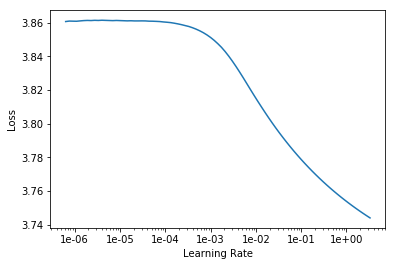

In [61]:
lr_find(learn)
learn.recorder.plot()

In [33]:
learn.predict(db.items[0])

(Category 0,
 tensor(0),
 tensor([[0.0282, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0048,
          0.0038, 0.0059, 0.0038, 0.0048, 0.0104, 0.0038, 0.0038, 0.0038, 0.0048,
          0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0048, 0.0104, 0.0038, 0.0038,
          0.0104, 0.0038, 0.0048, 0.0038, 0.0038, 0.0048, 0.0038, 0.0104, 0.0048,
          0.0040, 0.0039, 0.0038, 0.0038, 0.0104, 0.0038, 0.0038, 0.0038, 0.0048,
          0.0040, 0.0038, 0.0038, 0.0038, 0.0049, 0.0104, 0.0038, 0.0038, 0.0038,
          0.0038, 0.0038, 0.0040, 0.0038, 0.0038, 0.0048, 0.0104, 0.0038, 0.0038,
          0.0038, 0.0038, 0.0038, 0.0038, 0.0048, 0.0038, 0.0038, 0.0038, 0.0048,
          0.0038, 0.0048, 0.0040, 0.0104, 0.0038, 0.0048, 0.0038, 0.0048, 0.0104,
          0.0038, 0.0048, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038, 0.0048, 0.0038,
          0.0048, 0.0038, 0.0038, 0.0038, 0.0104, 0.0048, 0.0048, 0.0038, 0.0048,
          0.0038, 0.0038, 0.0104, 0.0104, 0.0038, 0.0038, 0.0054, 0.0038,

### AWD_LSTM Schema

```
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(8758, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(8758, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8758, bias=True)
    (output_dp): RNNDropout()
  )
)
```

## Fin.